# Imports

In [315]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm

from gensim.utils import simple_preprocess, tokenize
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Random state
RS = 42

In [46]:
# Read df
df = pd.read_csv('Downloads/blogtext.csv.zip')

# Data analysis

In [47]:
# Replace multiple spaces with one
df['text'] = df.text.replace('\s+', ' ', regex=True)
# Count words in texts and keep as a column
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
# Count posts by user and keep values in column
df['id_count'] = df.groupby('id').id.transform('count')
# Create age groups (4) and write values to column
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 30, 40, np.inf])

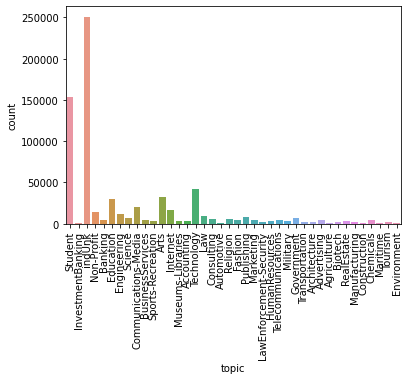

In [48]:
# Countplot of topics
f = sns.countplot(data=df, x='topic')
f.set_xticklabels(f.get_xticklabels(), rotation=90)
None

Most of texts are on Student or unknown (IndUnk) topic. Also, there are simmilar categories (like Biotech, Technology and Science), that could be hard to distinguish.

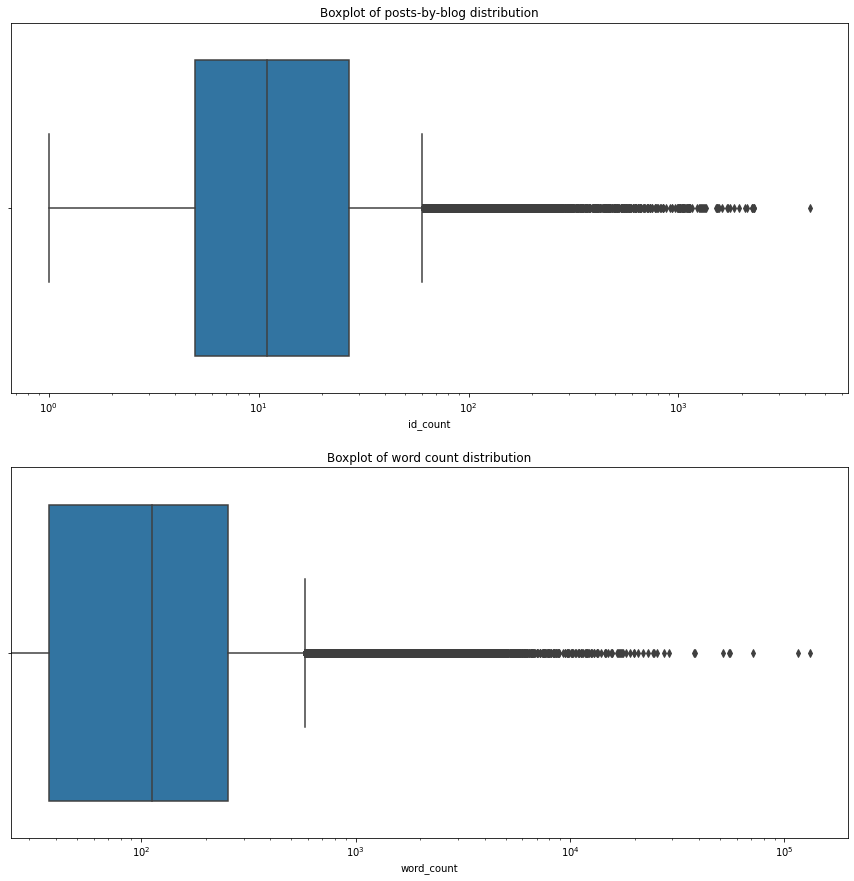

In [49]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plotting posts-by-blog distribution
f = sns.boxplot(x='id_count', data=df.drop_duplicates('id'), ax=axes[0])
f.set_title('Boxplot of posts-by-blog distribution')
f.set_xscale('log')

# Plotting word count distribution
f = sns.boxplot(x='word_count', data=df, ax=axes[1])
f.set_title('Boxplot of word count distribution')
f.set_xscale('log')

Most of posts are shorter than 1000 words, and most of users have less than 100 posts.

In [50]:
# Filter out blogs with unknown topic
df = df[df['topic'] != 'indUnk']
# Filter out empty posts
df = df[df.text != ' ']
# Filter out posts, longer than 1000 words and shorter than 4
df = df[(df.word_count > 4) & (df.word_count < 1000)]
# Filter out users with more than 100 posts
df = df[df.id_count < 100]

In [52]:
# Put tohether posts from same blog, because single post can be not informative or off-top. 
# Also, this step decreases df size and prevents data leakage
df_gr = df.groupby('id')['text'].apply(lambda x: '.'.join(x)).reset_index()
# Merge aggregated df with target values by id
df = pd.merge(df_gr, df[['id', 'topic', 'age_group', 'sign', 'gender']].drop_duplicates('id'), on='id', how='left')

In [53]:
df.shape

(11482, 6)

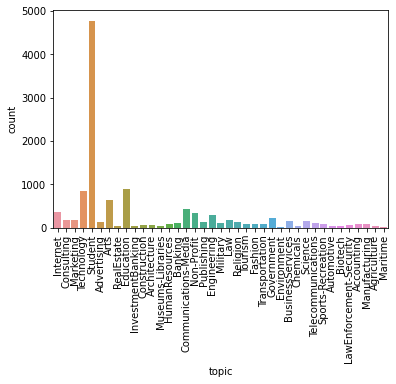

In [54]:
f = sns.countplot(data=df, x='topic')
f.set_xticklabels(f.get_xticklabels(), rotation=90)
None

Now Student is the most popular topic

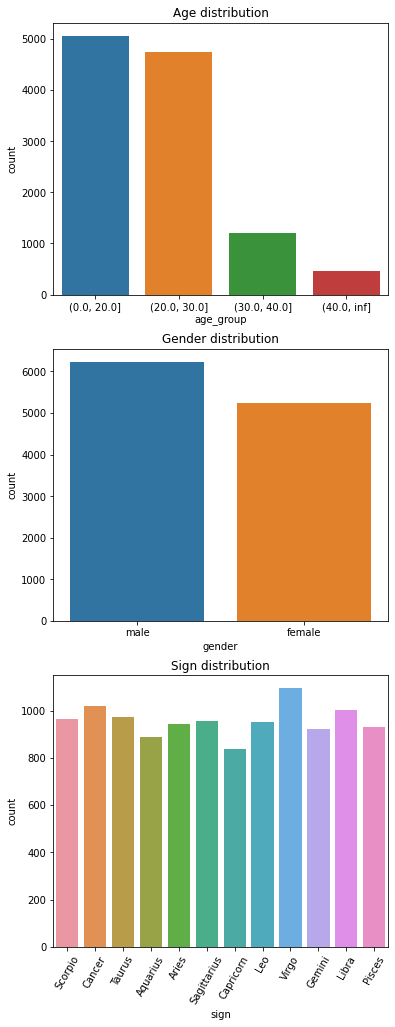

In [65]:
fig, axes = plt.subplots(3, 1, figsize=(6, 17))


f = sns.countplot(x='age_group', data=df, ax=axes[0])
f.set_title('Age distribution')

f = sns.countplot(x='gender', data=df, ax=axes[1])
f.set_title('Gender distribution')

f = sns.countplot(x='sign', data=df, ax=axes[2])
f.set_title('Sign distribution')
f.set_xticklabels(f.get_xticklabels(), rotation=60)
None

Most users are young (0-30) and there is more males than females. 
Zodiac sign distribution is regular.

# Doc2vec model

In [56]:
df.head()

,id,text,topic,age_group,sign,gender
0,7596,Every day should be a half day. Took the afte...,Internet,"(20.0, 30.0]",Scorpio,male
1,8349,"Ever wondered what a urlLink Bad head, or a h...",Consulting,"(20.0, 30.0]",Cancer,male
2,9289,with each and every passing day its hard to i...,Marketing,"(20.0, 30.0]",Taurus,male
3,11253,About to go t bed late (again) got sucked int...,Technology,"(20.0, 30.0]",Aquarius,male
4,11762,Entry originally posted on 8 August 2003 . Th...,Student,"(20.0, 30.0]",Aries,female


In [67]:
# Data splitting
x_train, x_val, y_train, y_val = train_test_split(df, df['topic'], train_size=0.8, shuffle=True, random_state=RS)

In [68]:
# Create tagged documents for doc2vec
train_tagged = x_train.apply(
    lambda x: TaggedDocument(words=list(simple_preprocess(x['text'])), tags=[x.id]), axis=1)
test_tagged = x_val.apply(
    lambda x: TaggedDocument(words=list(simple_preprocess(x['text'])), tags=[x.id]), axis=1)

In [170]:
# Example
train_tagged[1][0][0:10]

['ever',
 'wondered',
 'what',
 'urllink',
 'bad',
 'head',
 'or',
 'head',
 'crash',
 'on']

In [69]:
# Create doc2vec model and build vocab
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=4)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 9185/9185 [00:00<00:00, 208380.07it/s]


In [70]:
# Train model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=10)

In [71]:
# Doc vector construction function
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors 

In [72]:
# Doc vectors construction
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [176]:
# Example vector (50 of 300 values)
X_train[3][0:50]

array([0.55526856, 0.54397149, 0.41200742, 0.41943915, 0.36409257,
       0.52149315, 0.46929962, 0.66076787, 0.54485695, 0.54964298,
       0.55224963, 0.68598243, 0.60328062, 0.45627576, 0.51330794,
       0.53342611, 0.61840465, 0.54929988, 0.45365336, 0.45315527,
       0.72853521, 0.7931765 , 0.45761949, 0.4497355 , 0.22734599,
       0.58718066, 0.35487103, 0.75574157, 0.26025529, 0.46876894,
       0.66856552, 0.47698994, 0.60722015, 0.5174774 , 0.47435181,
       0.50569048, 0.296222  , 0.58517765, 0.5491271 , 0.46594156,
       0.54639068, 0.35424307, 0.62154745, 0.32173905, 0.50529356,
       0.42685012, 0.58090524, 0.53757214, 0.44554628, 0.46459906])

In [73]:
# Data scaling
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Topic prediction

In [74]:
# Topic encoding
enc_topic = LabelEncoder()
y_train = enc_topic.fit_transform(x_train['topic'])
y_val = enc_topic.transform(x_val['topic'])

In [123]:
# Model for topic prediction
model_topic = SVC(max_iter=10000, class_weight='balanced')
model_topic.fit(pd.DataFrame(X_train),y_train)

SVC(class_weight='balanced', max_iter=10000)

In [149]:
print(classification_report(enc_topic.inverse_transform(y_val), enc_topic.inverse_transform(model_topic.predict(X_test))))

                         precision    recall  f1-score   support

             Accounting       0.02      0.04      0.03        25
            Advertising       0.00      0.00      0.00        30
            Agriculture       0.00      0.00      0.00         5
           Architecture       0.00      0.00      0.00        14
                   Arts       0.11      0.22      0.14       113
             Automotive       0.00      0.00      0.00        12
                Banking       0.00      0.00      0.00        24
                Biotech       0.00      0.00      0.00        13
       BusinessServices       0.00      0.00      0.00        41
              Chemicals       0.00      0.00      0.00        14
   Communications-Media       0.11      0.41      0.18        86
           Construction       0.00      0.00      0.00        10
             Consulting       0.03      0.04      0.03        28
              Education       0.33      0.17      0.22       197
            Engineering 

/Users/yana/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


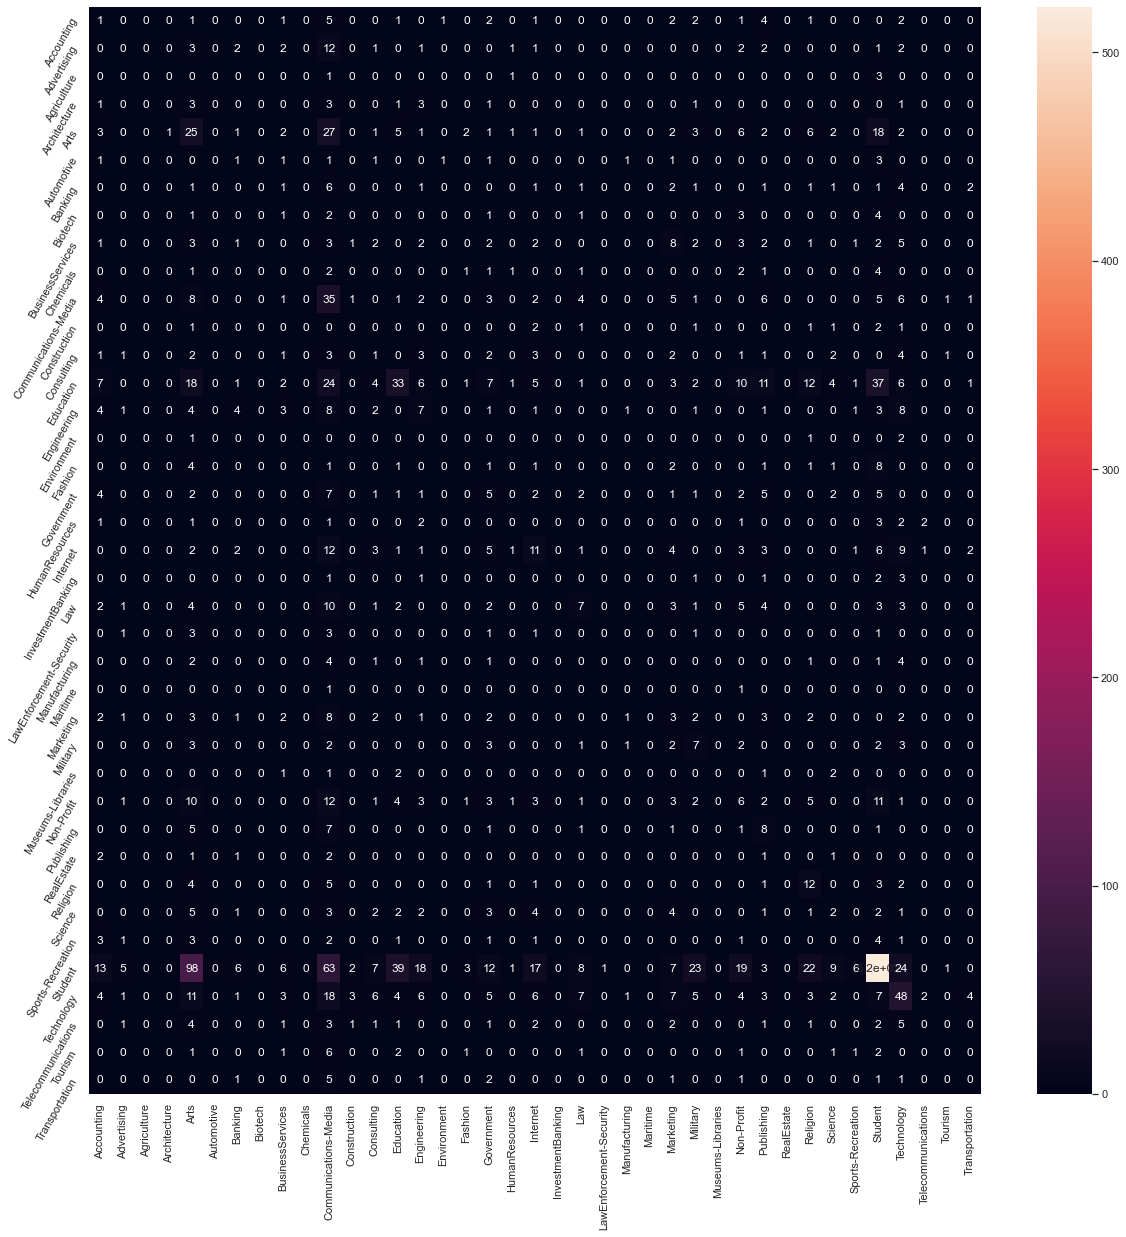

In [158]:
cm = confusion_matrix(y_val, model_topic.predict(X_test))

f = sns.heatmap(cm, annot=True)
sns.set(rc={'figure.figsize':(20,20)})
f.set_xticklabels(enc_topic.classes_, rotation=90)
f.set_yticklabels(enc_topic.classes_, rotation=60)
None

Topic prediction is not really accurate (weighted precision is 0.4, accuracy is 0.32). It can be improved by aggregating simmilar classes into one.

# Age prediction

In [105]:
# Age encoding
enc_age = LabelEncoder()
y_train_age = enc_age.fit_transform(x_train['age_group'])
y_val_age = enc_age.transform(x_val['age_group'])

In [107]:
# Model for age prediction
model_age = SVC(max_iter=10000, class_weight='balanced')
model_age.fit(pd.DataFrame(X_train),y_train_age)

SVC(class_weight='balanced', max_iter=10000)

In [113]:
print(classification_report(list(map(str,enc_age.inverse_transform(y_val_age))), 
                            list(map(str,enc_age.inverse_transform(model_age.predict(X_test))))))

              precision    recall  f1-score   support

 (0.0, 20.0]       0.92      0.88      0.90      1008
(20.0, 30.0]       0.79      0.73      0.76       954
(30.0, 40.0]       0.39      0.54      0.45       245
 (40.0, inf]       0.20      0.26      0.22        90

    accuracy                           0.76      2297
   macro avg       0.58      0.60      0.58      2297
weighted avg       0.78      0.76      0.77      2297



# Gender prediction

In [115]:
# Gender encoding
enc_gender = LabelEncoder()
y_train_gender = enc_gender.fit_transform(x_train['gender'])
y_val_gender = enc_gender.transform(x_val['gender'])

In [116]:
model_gender = SVC(max_iter=10000, class_weight='balanced')
model_gender.fit(pd.DataFrame(X_train),y_train_gender)

SVC(class_weight='balanced', max_iter=10000)

In [117]:
print(classification_report(enc_gender.inverse_transform(y_val_gender), 
                            enc_gender.inverse_transform(model_gender.predict(X_test))))

              precision    recall  f1-score   support

      female       0.79      0.82      0.81      1065
        male       0.84      0.81      0.83      1232

    accuracy                           0.82      2297
   macro avg       0.82      0.82      0.82      2297
weighted avg       0.82      0.82      0.82      2297



# Sign prediction

In [118]:
enc_sign = LabelEncoder()
y_train_sign = enc_sign.fit_transform(x_train['sign'])
y_val_sign = enc_sign.transform(x_val['sign'])

In [119]:
model_sign = SVC(max_iter=10000, class_weight='balanced')
model_sign.fit(pd.DataFrame(X_train),y_train_sign)

SVC(class_weight='balanced', max_iter=10000)

In [120]:
print(classification_report(enc_sign.inverse_transform(y_val_sign), 
                            enc_sign.inverse_transform(model_sign.predict(X_test))))

              precision    recall  f1-score   support

    Aquarius       0.08      0.08      0.08       196
       Aries       0.06      0.04      0.05       201
      Cancer       0.09      0.19      0.12       210
   Capricorn       0.04      0.04      0.04       162
      Gemini       0.10      0.11      0.11       166
         Leo       0.08      0.12      0.09       157
       Libra       0.05      0.07      0.06       193
      Pisces       0.10      0.08      0.09       177
 Sagittarius       0.09      0.05      0.06       182
     Scorpio       0.05      0.03      0.04       207
      Taurus       0.11      0.04      0.06       206
       Virgo       0.11      0.08      0.09       240

    accuracy                           0.08      2297
   macro avg       0.08      0.08      0.08      2297
weighted avg       0.08      0.08      0.08      2297



I didn't expect good results  here.

# Final prediction

In [177]:
# Finction for user classification
def classify_usr(vec, model_topic, model_age, model_gender, model_sign, enc_topic, enc_age, enc_gender, enc_sign):
    '''
    Keyword arguments:
    vec - doc2vec vector of blog
    model_topic - fitted model for topic classification
    model_age - fitted model for age classification
    model_gender - fitted model for gender classification
    model_sign - fitted model for sign classification
    enc_topic - fitted encoder for topic
    enc_age - fitted encoder for age
    enc_gender - fitted encoder for gender
    enc_sign - fitted encoder for sign   
    '''
    vec = vec.reshape(1, -1)
    topic = enc_topic.inverse_transform(model_topic.predict(vec))[0]
    age = enc_age.inverse_transform(model_age.predict(vec))[0]
    gender = enc_gender.inverse_transform(model_gender.predict(vec))[0]
    sign = enc_sign.inverse_transform(model_sign.predict(vec))[0]
    
    print(f'Topic: {topic}; Age: {str(age)}; Gender: {gender}; Sign: {sign}')

In [144]:
# Classification result
classify_usr(X_test[1], model_topic, model_age, model_gender, model_sign, enc_topic, enc_age, enc_gender, enc_sign)

Topic: Student; Age: (0.0, 20.0]; Gender: male; Sign: Virgo


In [147]:
# Actual values
x_val.iloc[1,:]

id                                                     3440159
text          So... we're screwed. It's official. The Ice c...
topic                                                  Student
age_group                                          (0.0, 20.0]
sign                                                  Aquarius
gender                                                    male
Name: 3288, dtype: object

## Test on real example

In [206]:
# Source of example https://realpython.com/python-enumerate/
example = 'In Python, a for loop is usually written as a loop over an iterable object. \
This means you don’t need a counting variable to access items in the iterable. Sometimes, \
though, you do want to have a variable that changes on each loop iteration.\
Rather than creating and incrementing a variable yourself, you can use Python’s enumerate()\
to get a counter and the value from the iterable at the same time!'

In [208]:
# Create tagged document
example_tagged = TaggedDocument(words=list(simple_preprocess(example)), tags=['ex'])
# Create vector
example_vec = model_dbow.infer_vector(example_tagged.words, steps=20)
# Scaling
example_vec = sc.transform(example_vec.reshape(1, -1))
# Classification
classify_usr(example_vec, model_topic, model_age, model_gender, model_sign, enc_topic, enc_age, enc_gender, enc_sign)

Topic: Technology; Age: (20.0, 30.0]; Gender: male; Sign: Cancer


It looks true!

## How to improve?

There are some ways to improve my classification. If you have good enough hardware, you can try some hype methods like BERT. Also, all models can be improved with hyperparameters tuning.